In [38]:
import torch
import torchvision
from tqdm.notebook import tqdm
import numpy as np

In [39]:
n_epochs = 3
batch_size_train = 1000
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Import Data

In [40]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

## Demonstration of Classical PCA

In [41]:
iter_data = iter(train_loader) 
images, labels = next(iter_data)

In [42]:
images_numpy = images.numpy().reshape(1000,-1)
labels_numpy = labels.numpy()

print(np.shape(images_numpy),
      np.shape(labels_numpy))

(1000, 784) (1000,)


In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=5)
X_low_dim = pca.fit_transform(images_numpy)
np.shape(X_low_dim)

(1000, 5)

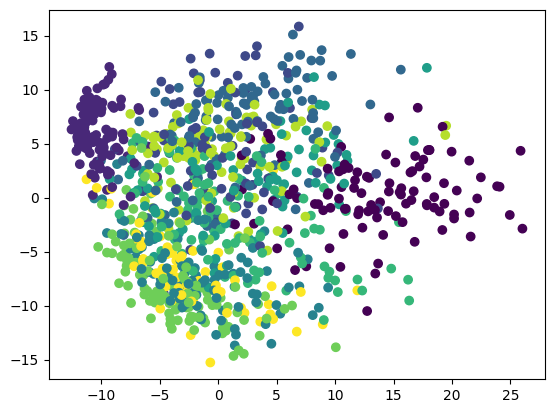

In [44]:
plt.scatter(X_low_dim[:,0], X_low_dim[:,1], c=labels_numpy)

## Demonstration of Digit Classification

Ref : https://nextjournal.com/gkoehler/pytorch-mnist

In [45]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [46]:
example_data.shape

torch.Size([1000, 1, 28, 28])

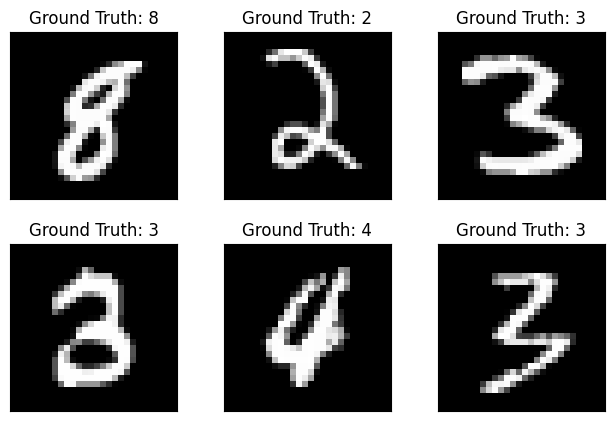

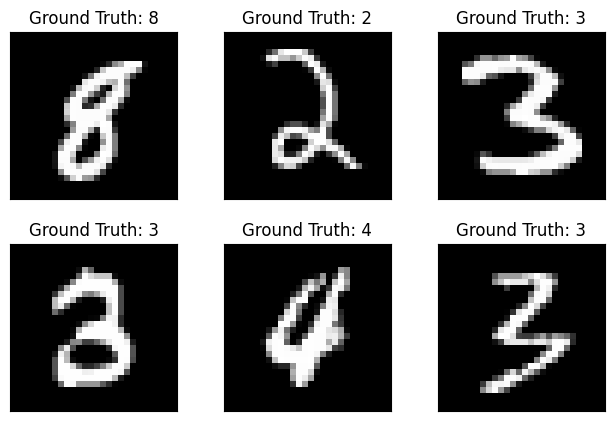

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Neural Network

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Optimizer

In [50]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [51]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

### Train

In [52]:
def train(epoch):
  network.train()

  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
    
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #  epoch, batch_idx * len(data), len(train_loader.dataset),
      #  100. * batch_idx / len(train_loader), loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

### Test

In [53]:
def test():

  network.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader)):
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  
  #print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  #  test_loss, correct, len(test_loader.dataset),
  #  100. * correct / len(test_loader.dataset)))

In [54]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\dalbe\AppData\Local\Temp\ipykernel_43736\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\dalbe\anaconda3\envs\ML\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3210, Accuracy: 1038/10000 (10%)



  0%|          | 0/60 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308540
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.316746
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.297521
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.283830
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.272103
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.252733


  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Avg. loss: 2.2145, Accuracy: 3999/10000 (40%)



  0%|          | 0/60 [00:00<?, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.236170
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.215006
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.172586
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.127919
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.085753
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.987415


  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Avg. loss: 1.7382, Accuracy: 6133/10000 (61%)



  0%|          | 0/60 [00:00<?, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.877898
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.828373
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.724574
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.650651
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.527321
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.475364


  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Avg. loss: 0.9948, Accuracy: 7874/10000 (79%)



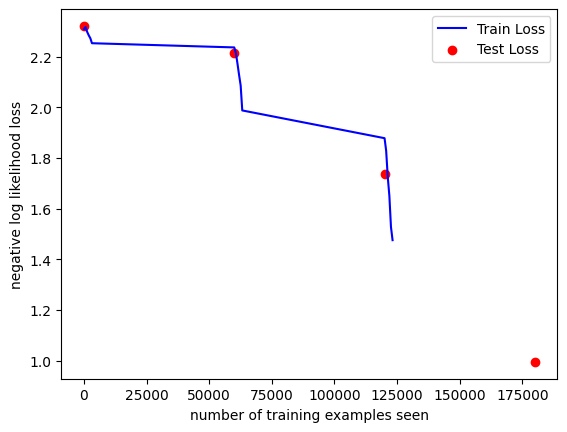

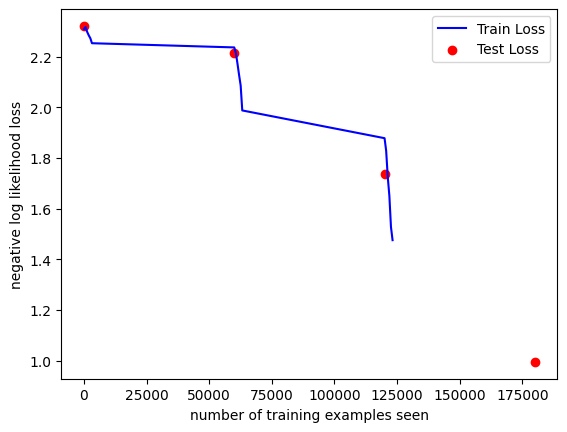

In [55]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig